In [1]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data
from scipy.stats import sem
from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline
# Downloading NLTK resources
# nltk.download('stopwords')

In [2]:
df = pd.read_feather("../Data/Data1.feather")

In [3]:
df.head(5)

,text,company_names,sentiment,base_url
0,video offic mind busi david solomon tell gs in...,goldman sach,0,twitter.com
1,price lumber lb f sinc hit ytd high maci turna...,maci,0,twitter.com
2,say american dream dead,american,-1,buff.ly
3,barri silbert extrem optimist bitcoin predict ...,bitcoin,1,twitter.com
4,satellit avoid attack space junk circl earth paid,oracl,-1,on.forbes.com


In [4]:
X = df[['text', 'base_url', 'company_names']]
Y = df['sentiment']

In [5]:
stop_words_appened=stopwords.words('english').append(['rt', 'ep'])

In [6]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer_text.transform(X_test['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_url = tfidf_vectorizer_url.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer_url.transform(X_test['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_company = tfidf_vectorizer_url.fit_transform(X_train['company_names'])
X_test_tfidf_company = tfidf_vectorizer_url.transform(X_test['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_train_tfidf_combined = hstack([X_train_tfidf_text, X_train_tfidf_url, X_train_tfidf_company])
X_test_tfidf_combined = hstack([X_test_tfidf_text, X_test_tfidf_url, X_test_tfidf_company])


## Vanilla Random Forest

In [28]:
# Creating and training the random forest model
forest_tf = RandomForestClassifier(random_state=50, oob_score=True)
forest_tf.fit(X_train_tfidf_combined, y_train)

# Predicting on the test set
y_pred = forest_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate OOB score
oob_score = forest_tf.oob_score_
print("Out-of-Bag (OOB) Score:", oob_score)

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9501133786848073
Out-of-Bag (OOB) Score: 0.9477294631214922
              precision    recall  f1-score   support

          -1       0.95      0.79      0.86       425
           0       0.94      0.98      0.96      2687
           1       0.96      0.94      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.95      0.90      0.92      4410
weighted avg       0.95      0.95      0.95      4410



In [29]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 334,   76,   15],
       [  15, 2641,   31],
       [   2,   81, 1215]])

In [30]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

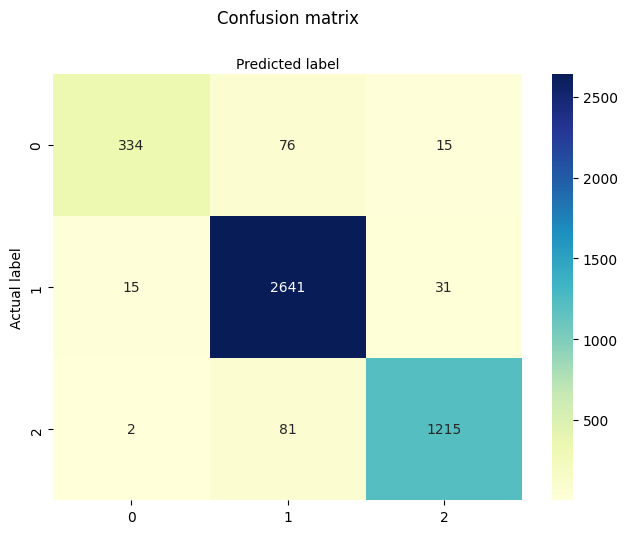

In [31]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

## Random Forest classifier with feature bagging

In [32]:
forest_tf = RandomForestClassifier(max_features='sqrt', oob_score=True)
forest_tf.fit(X_train_tfidf_combined, y_train)

# Predicting on the test set
y_pred = forest_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9487528344671202
              precision    recall  f1-score   support

          -1       0.93      0.79      0.86       425
           0       0.94      0.98      0.96      2687
           1       0.97      0.93      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.95      0.90      0.92      4410
weighted avg       0.95      0.95      0.95      4410



In [33]:
# Calculate OOB score
oob_score = forest_tf.oob_score_
print("Out-of-Bag (OOB) Score:", oob_score)

Out-of-Bag (OOB) Score: 0.9464822268836102


In [34]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 336,   74,   15],
       [  22, 2638,   27],
       [   2,   86, 1210]])

In [35]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

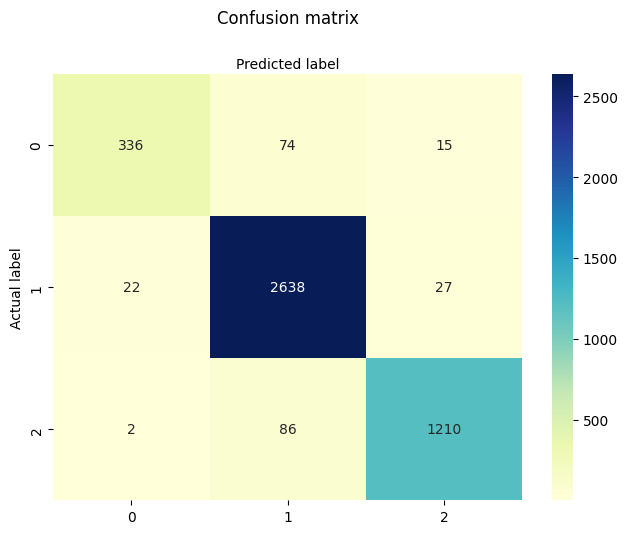

In [36]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

## Random Forest with Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

forest_tf = GradientBoostingClassifier(n_estimators=50, learning_rate=.25, max_depth=10)
forest_tf.fit(X_train_tfidf_combined, y_train)
# Predicting on the test set
y_pred = forest_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9448979591836735
              precision    recall  f1-score   support

          -1       0.89      0.78      0.83       425
           0       0.94      0.98      0.96      2687
           1       0.97      0.93      0.95      1298

    accuracy                           0.94      4410
   macro avg       0.93      0.89      0.91      4410
weighted avg       0.94      0.94      0.94      4410



##  Voting Classifier with Random Forest 

In [27]:
from sklearn.ensemble import VotingClassifier

# three Random Forest classifiers
rf1 = RandomForestClassifier(n_estimators=100)
rf2 = RandomForestClassifier(n_estimators=70)
rf3 = RandomForestClassifier(n_estimators=80)

# Create Voting Classifier with 3 Random Forest models
voting_clf = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)])
# Train the voting classifier
voting_clf.fit(X_train_tfidf_combined, y_train)
# Make predictions
y_pred = voting_clf.predict(X_test_tfidf_combined)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9503401360544218
              precision    recall  f1-score   support

          -1       0.96      0.78      0.86       425
           0       0.94      0.98      0.96      2687
           1       0.96      0.94      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.96      0.90      0.92      4410
weighted avg       0.95      0.95      0.95      4410



## Bag of word Vectorizer

In [39]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)

# Fitting and transforming the text training set
X_train_bow_text = bow_vectorizer_text.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer_text.transform(X_test['text'])
bow_vectorizer_url = CountVectorizer(max_features=1000)

# Fitting and transforming the url training set
X_train_bow_url = bow_vectorizer_url.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer_url.transform(X_test['base_url'])
X_train_bow_company_name = bow_vectorizer_url.fit_transform(X_train['company_names'])
X_test_bow_company_name = bow_vectorizer_url.transform(X_test['company_names'])
X_train_bow_combined = hstack([X_train_bow_text, X_train_bow_url, X_train_bow_company_name])
X_test_bow_combined = hstack([X_test_bow_text, X_test_bow_url, X_test_bow_company_name])


In [45]:
# Creating and training the vanilla random forest model for bow
forest_bow = RandomForestClassifier(random_state=50, oob_score=True)
forest_bow.fit(X_train_bow_combined, y_train)

# Predicting on the test set
y_pred = forest_bow.predict(X_test_bow_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate OOB score
oob_score = forest_bow.oob_score_
print("Out-of-Bag (OOB) Score:", oob_score)

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.954875283446712
Out-of-Bag (OOB) Score: 0.9481263110153637
              precision    recall  f1-score   support

          -1       0.96      0.81      0.88       425
           0       0.95      0.99      0.97      2687
           1       0.97      0.94      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.96      0.91      0.93      4410
weighted avg       0.96      0.95      0.95      4410



In [41]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 343,   66,   16],
       [  12, 2647,   28],
       [   3,   74, 1221]])

In [42]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

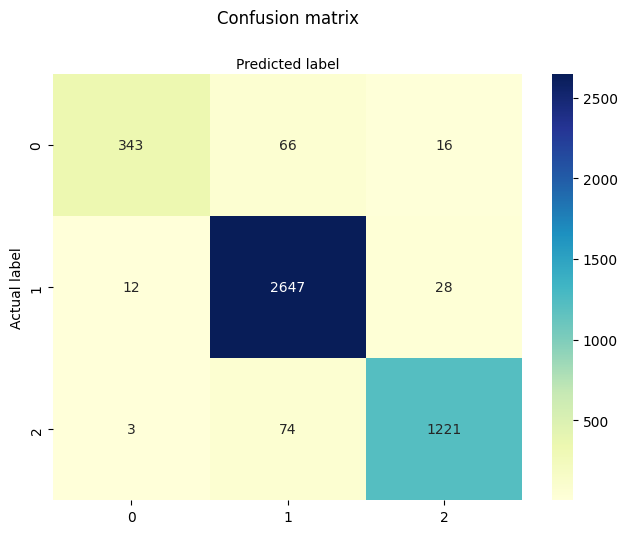

In [43]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

## Random Forest classifier with feature bagging

In [47]:
forest_bow = RandomForestClassifier(max_features='sqrt', oob_score=True)
forest_bow.fit(X_train_bow_combined, y_train)

# Predicting on the test set
y_pred = forest_bow.predict(X_test_bow_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.953514739229025
              precision    recall  f1-score   support

          -1       0.96      0.80      0.87       425
           0       0.95      0.98      0.97      2687
           1       0.96      0.94      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.96      0.91      0.93      4410
weighted avg       0.95      0.95      0.95      4410



In [48]:
# Calculate OOB score
oob_score = forest_bow.oob_score_
print("Out-of-Bag (OOB) Score:", oob_score)

Out-of-Bag (OOB) Score: 0.9473326152276206


In [49]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 341,   69,   15],
       [  12, 2643,   32],
       [   4,   73, 1221]])

In [50]:
# printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

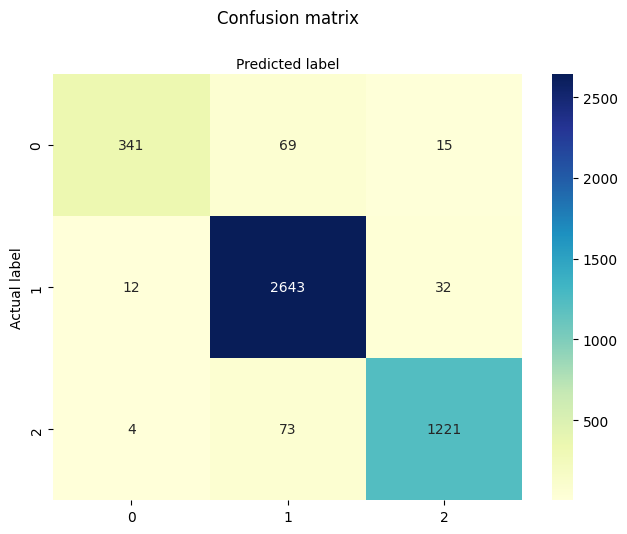

In [51]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

## Random Forest with Boosting

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

forest_bow = GradientBoostingClassifier(n_estimators=50, learning_rate=.25, max_depth=10)
forest_bow.fit(X_train_bow_combined, y_train)
# Predicting on the test set
y_pred = forest_bow.predict(X_test_bow_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9532879818594104
              precision    recall  f1-score   support

          -1       0.94      0.79      0.86       425
           0       0.95      0.99      0.97      2687
           1       0.98      0.93      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.95      0.90      0.93      4410
weighted avg       0.95      0.95      0.95      4410



##  Voting Classifier with Random Forest 

In [53]:
from sklearn.ensemble import VotingClassifier

# three Random Forest classifiers
rf1 = RandomForestClassifier(n_estimators=100)
rf2 = RandomForestClassifier(n_estimators=70)
rf3 = RandomForestClassifier(n_estimators=80)

# Create Voting Classifier with 3 Random Forest models
voting_clf = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)])
# Train the voting classifier
voting_clf.fit(X_train_bow_combined, y_train)
# Make predictions
y_pred = voting_clf.predict(X_test_bow_combined)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9532879818594104
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       425
           0       0.95      0.98      0.97      2687
           1       0.97      0.94      0.95      1298

    accuracy                           0.95      4410
   macro avg       0.95      0.91      0.93      4410
weighted avg       0.95      0.95      0.95      4410



# Repeated K-Fold Cross Validation

In [54]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_company = tfidf_vectorizer_company.fit_transform(X['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url, X_tfidf_company])

In [55]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

bow_vectorizer_company = CountVectorizer(max_features=1000)
X_bow_company = bow_vectorizer_company.fit_transform(X['company_names'])

X_bow_combined = hstack([X_bow_text, X_bow_url, X_bow_company])

In [56]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    forest1 =  RandomForestClassifier(random_state=50, oob_score=True)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(forest1, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>1 mean=0.9503 se=0.002
>2 mean=0.9505 se=0.001
>3 mean=0.9506 se=0.001
>4 mean=0.9506 se=0.001
>5 mean=0.9506 se=0.001
>6 mean=0.9507 se=0.001
>7 mean=0.9508 se=0.001
>8 mean=0.9507 se=0.001
>9 mean=0.9508 se=0.001


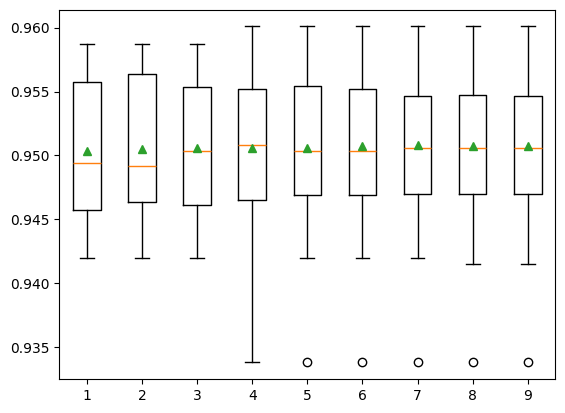

In [57]:
repeats = range(1,10)
results = list()
from scipy.stats import sem
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, Y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

>1 mean=0.9526 se=0.001
>2 mean=0.9526 se=0.001
>3 mean=0.9527 se=0.001
>4 mean=0.9524 se=0.001
>5 mean=0.9526 se=0.001
>6 mean=0.9525 se=0.001
>7 mean=0.9525 se=0.001
>8 mean=0.9526 se=0.001
>9 mean=0.9526 se=0.000


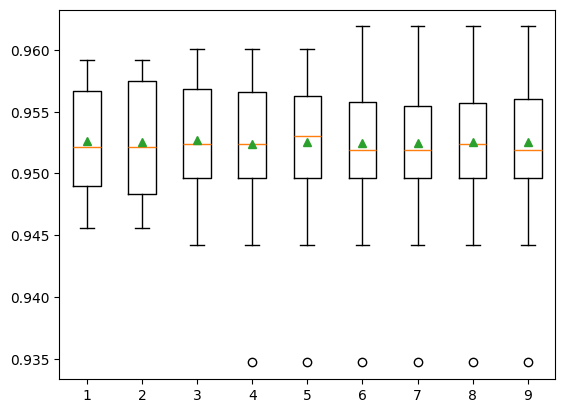

In [58]:
repeats = range(1,10)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, Y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

## Hyper parameter tunning of Random Forest

## Grid Search

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
forest_gd = RandomForestClassifier(random_state=43)
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [20, 50, 100, 120],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4, 6]
}
GS = GridSearchCV(estimator=forest_gd,param_grid=param_grid,cv=10,n_jobs=-1, verbose=True, scoring='accuracy')

In [73]:
GS.fit(X_bow_combined, Y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=43),
             n_jobs=-1,
             param_grid={'max_depth': [20, 50, 100, 120],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 70, 100]},
             scoring='accuracy', verbose=True)

In [74]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'max_depth': 120, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Best Score: 0.9347344963393706


## RandomizedSearch CV

In [75]:
from sklearn.model_selection import RandomizedSearchCV

In [76]:
forest_RS = RandomForestClassifier(random_state=43)
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [20, 50, 100, 120],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4, 6]
}
RS = RandomizedSearchCV(estimator=forest_RS,param_distributions=param_grid,cv=10,n_iter=300,n_jobs=-1, verbose=True, scoring='accuracy')

In [77]:
RS.fit(X_bow_combined, Y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/Users/erhubsa/Documents/Sentiment_Analysis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=300. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=43),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': [20, 50, 100, 120],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 70, 100]},
                   scoring='accuracy', verbose=True)

In [78]:
print('Best Parameters:',RS.best_params_,end='\n\n')
print('Best Score:',RS.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 120}

Best Score: 0.9347344963393706
